# Magic BERT
#### Investigating the similarity of MtG flavor text with a large language model

We will be using the [Sentence-BERT](https://arxiv.org/abs/1908.10084) (SBERT) model, which has been pretrained and optimized for finding similarities in text. It is designed to provide meaningful embeddings of sentences such that outputs with low cosine distance will have very similar semantic content. To do so we will create a sentence-transformer using the [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) model, which according to the experts at [SBERT](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models) has the highest performance on these types of tasks.

---

This notebook is based off of the [NLP Course](https://huggingface.co/learn/nlp-course/en) from HuggingFace and [this Geeks for Geeks post](https://www.geeksforgeeks.org/sentence-similarity-using-bert-transformer/).


In [1]:
import numpy as np
import torch

# Create Model Object
from sentence_transformers import SentenceTransformer
# device = torch.device("mps")
model = SentenceTransformer("all-mpnet-base-v2",device='mps')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gordonpetty/opt/anaconda3/envs/ernie/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Let's make up some flavor text! We will then run it through our model to see which are the most similar. 
Here I am writing two sentences about goblins and their odor, which should have a high similarity metric. The other two sentences are meant to sound like generic flavor text from Blue or Black cards, and should be dissimilar to each other and the two lines about Goblins. 

In [2]:
my_flavor_text = ["Goblins sure do smell bad.",
    "Those goblins are loud and offensive!",
    "The mind is the purest distillation of progress.",
    "My power over death makes me unstoppable"]

In [3]:
# By default the model uses Cosine Similarity as the similarity metric.
embeddings = model.encode(my_flavor_text)
similarities = model.similarity(embeddings,embeddings)
print(similarities)

tensor([[ 1.0000,  0.6725,  0.0113,  0.0721],
        [ 0.6725,  1.0000, -0.0032,  0.1065],
        [ 0.0113, -0.0032,  1.0000,  0.2725],
        [ 0.0721,  0.1065,  0.2725,  1.0000]])


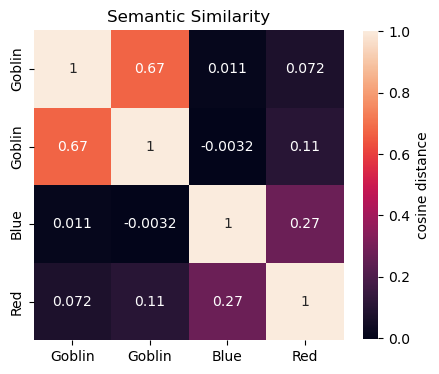

In [4]:
# Next we can visualize the similarities with a heat map matrix using Seaborn
import seaborn as sns
from matplotlib import pyplot as plt

labels = ['Goblin','Goblin','Blue','Red']
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(similarities, annot=True,
            xticklabels=labels,yticklabels=labels,
            square=True,cbar_kws={'shrink':0.8,'label':'cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

As expected, the first two lines of text are very similar to eachother, while the remaining two are relatively dissimilar.

## Now, let's take a look at actual flavor text! 

Our hypothesis is that red cards will be most similar to other red cards, blue cards similar to other blue cards, and so forth.
To reduce computation time and simplify visualization, we will start with 500 cards: 100 monocolored cards from each of the five colors. 

In [5]:
# Load card data
# - We downloaded this earlier in the Colorful_Flavor notebook
import pickle
import pandas as pd
datapath = 'card_data/CardData.pkl'
with open(datapath,'rb') as file:    
    data = pickle.load(file)

# Simplify dataframe to relevant information
data = data.loc[:,['name','type_line','set','mana_cost','colors','flavor_text']].reset_index(drop=True)

# Identify monocolored cards
is_monocolored = data['colors'].apply(lambda x : np.shape(x) == (1,))
data['monocolored'] = is_monocolored

In [6]:
# Subset 100 random monocolored cards from each color
# Set a random seed for replicability:
np.random.seed(31)
colors = ['W','U','B','R','G']
mono_cards = data.loc[data['monocolored'],:]
# Drop repeated cards, as some of them have repeated flavor text in slightly different formatting.
# Pandas "duplicates" can't find this, simply dropping duplicate cards is aggressive but will ensure no duplicate flavor text
mono_cards = mono_cards.drop_duplicates(subset ='name')
card_subsample = pd.concat([mono_cards.loc[mono_cards['colors'].explode() == color,:].sample(100) for color in colors])
card_subsample = card_subsample.reset_index(drop=True)
print('Some example monocolored cards')
card_subsample.sample(10)

Some example monocolored cards


,name,type_line,set,mana_cost,colors,flavor_text,monocolored
147,Magnetic Flux,Instant,dst,{2}{U},[U],"after the researcher's astonishing success, hi...",True
369,Uncanny Speed,Instant,avr,{1}{R},[R],"""to survive, we must embrace the savagery we k...",True
465,Heartwood Storyteller,Creature — Treefolk,tsr,{1}{G}{G},[G],"his roots reach deep, nurtured not by soil and...",True
154,Telekinetic Sliver,Creature — Sliver,tsp,{2}{U}{U},[U],"""slivers are guided only by simple instinct. a...",True
164,Jace's Sanctum,Enchantment,c19,{3}{U},[U],"""for all our lofty talk of keeping watch, we h...",True
74,Divine Gambit,Sorcery,sta,{W}{W},[W],"""evil is to be unshackled, not slain. unlock y...",True
193,Birthday Escape,Sorcery,ltr,{U},[U],"as bilbo finished his speech, he slipped the r...",True
271,Mark of the Vampire,Enchantment — Aura,uma,{3}{B},[B],"""my 'condition' is a trial. the weak are consu...",True
138,Shipwreck Sentry,Creature — Human Pirate,lci,{1}{U},[U],"""that's close enough, stranger.""",True
101,Mind's Dilation,Enchantment,otc,{5}{U}{U},[U],infinite wisdom cannot be contained within a s...,True


In [7]:
# Extract the flavor text column from our data frame and run it through our model
flavor_text_sample = card_subsample['flavor_text'].to_numpy()
embeddings = model.encode(flavor_text_sample)
similarities = model.similarity(embeddings,embeddings)


card_subsample['embedding'] = list(embeddings)

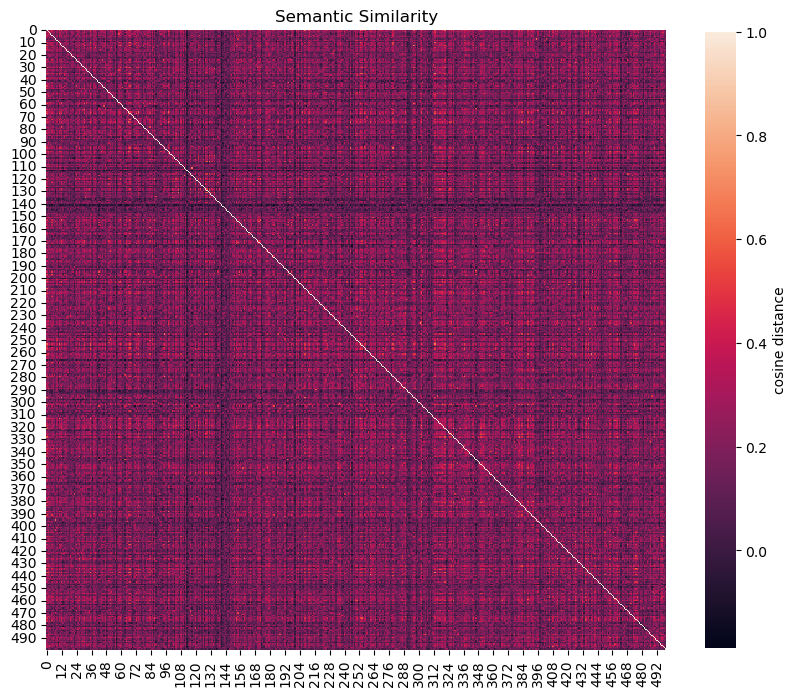

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(similarities, annot=False,
            square=True,cbar_kws={'shrink':0.8,'label':'cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

Despite putting the flavor text in order of color, there doesn't seem to be any underlying structure. That is to say, there are no obvious clusters of cards that might align with colors. 

Let's take a closer look at which cards are most and least similar

In [9]:
sim_np = similarities.numpy() # from tensor to np array
np.fill_diagonal(sim_np,0)
# Fill the upper triangle of the matrix with zeros so we don't get repeated pairs
sim_np = np.tril(sim_np)

In [10]:
# Look for the top 10 most similar pairs of text:
# Unravel similarities
sim_np_unravel = sim_np.reshape(-1)
x,y = np.unravel_index(np.argpartition(sim_np_unravel,-10),sim_np.shape)
# each x-y pair corresponds to a pair of flavor texts. 
# Iterate through them and print out each pair along with their similarity scores
# (Note that the scores are unsorted, but last 10 are guaranteed to be the top 10 highest scores)
x_top = x[-10:]
y_top = y[-10:]
# Sort descending:
coords = [(xx,yy) for xx,yy in zip(x[-10:],y[-10:])]
max_vals = [sim_np[x,y] for x,y in coords]
sort_order = np.flip(np.argsort(max_vals))
x_top = x_top[sort_order]
y_top = y_top[sort_order]
for i in range(len(x_top)):
    sim_score = float(sim_np[x_top[i]][y_top[i]])
    print(card_subsample['name'][x_top[i]],"    ",card_subsample['colors'][x_top[i]])
    print("   ",flavor_text_sample[x_top[i]])
    print("")
    print(card_subsample['name'][y_top[i]],"    ",card_subsample['colors'][y_top[i]])
    print("   ",flavor_text_sample[y_top[i]])
    print(" ")
    print(f"Similarity Score = {np.round(sim_score,3)}")
    print('---------------------------------------------')

Terrain Elemental      ['G']
    "you tread upon the land all the time, yet you seem dismayed when it moves to step on you."
—nissa revane

Sidewinder Naga      ['G']
    "those who embrace the harsh land rather than fight it find they have a powerful ally."
—nissa revane
 
Similarity Score = 0.722
---------------------------------------------
In the Web of War      ['R']
    "in desperation, konda sent warriors to parley with the ogre-magi. no one knows whether they were slaughtered at shinka or if they even reached its bloodstained walls."
—*observations of the kami war*

Three Tragedies      ['B']
    "as the kami passed over the village of mita, the inhabitants relived their three most grievous tragedies. some cried. some raged. some were driven to madness. but the next morning, none possessed the will to fight."
—*observations of the kami war*
 
Similarity Score = 0.709
---------------------------------------------
Elephant Guide      ['G']
    nature's strength outlives the stron

The vibes of these passages seem to line up well with eachother, but the colors of cards don't always align.\
It also appears that passages quoted by the same character are often paired together.\
Now let's take a look at the lowest scores and see if they look wildly different:

In [11]:
# First replace all 0's with 1's so that we can still ignore the diagonal and upper triangle
# (here we don't bother sorting)
sim_np[sim_np == 0] = 1
x,y = np.unravel_index(np.argpartition(sim_np_unravel,5),sim_np.shape)
sim_np_unravel = sim_np.reshape(-1)
x_top = x[:5]
y_top = y[:5]
for i in range(len(x_top)):
    sim_score = float(sim_np[x_top[i]][y_top[i]])
    print(card_subsample['name'][x_top[i]],"    ",card_subsample['colors'][x_top[i]])
    print("   ",flavor_text_sample[x_top[i]])
    print("")
    print(card_subsample['name'][y_top[i]],"    ",card_subsample['colors'][y_top[i]])
    print("   ",flavor_text_sample[y_top[i]])
    print(" ")
    print(f"Similarity Score = {np.round(sim_score,3)}")
    print('---------------------------------------------')

Vigilant Drake      ['U']
    awake and awing in the blink of an eye.

Dauntless Dismantler      ['W']
    to their dismay, brazen coalition explorers soon found that the oltec were not impressed by cannons.
 
Similarity Score = -0.184
---------------------------------------------
Kami of Terrible Secrets      ['B']
    it feeds on things better left unknown, savoring the bitterness of lies and regrets.

Tasseled Dromedary      ['W']
    there is no dress code for the inventors' fair, but you'll be hard-pressed to find anyone or anything not done up in their finest.
 
Similarity Score = -0.176
---------------------------------------------
Spawning Grounds      ['G']
    it's the only water source in miles of desert, but the local tribes avoid it at all costs.

Vigilant Drake      ['U']
    awake and awing in the blink of an eye.
 
Similarity Score = -0.188
---------------------------------------------
Spawning Grounds      ['G']
    it's the only water source in miles of desert, but th

While it is difficult to say if these pairs are truly *disparate* in some way, they certainly different vibes than those flavor text pairs that are most similar.

### Comparing cards by their relationship to all cards in a color

From our previous matrix, it is difficult to say how similar cards within a color are to eachother compared to other colors. Here we will measure that explicitly by taking the average similarity of each card to each other card, broken down by color.

In [14]:
# Reset the similarity matrix so we no longer ignore the upper triangle:
sim_np = similarities.numpy() # from tensor to np array
color_vect = card_subsample.colors.to_numpy()
for i in card_subsample.index:
    for c in colors:
        color_inds = card_subsample.loc[card_subsample.colors.explode() == c,:].index
        color_inds = color_inds[color_inds != i]
        color_similarities = sim_np[i,color_inds]
        color_sim_mean = np.mean(color_similarities)
        column_name = c[0]+"_mean_similarity"
        card_subsample.loc[i,column_name] = color_sim_mean

In [27]:
card_subsample.sample(10)

,name,type_line,set,mana_cost,colors,flavor_text,monocolored,embedding,W_mean_similarity,U_mean_similarity,B_mean_similarity,R_mean_similarity,G_mean_similarity
262,Butcher's Glee,Instant,ima,{2}{B},[B],the crave made kneecleaver think she was bigge...,True,"[0.030409645, -0.0010353363, -0.0009474368, 0....",0.139340,0.149275,0.164708,0.160077,0.167915
109,Projektor Inspector,Creature — Human Detective,mkm,{2}{U},[U],"""bring up the particulars from yesterday's alt...",True,"[0.027281933, -0.000763327, -0.0326855, -0.035...",0.146909,0.137921,0.112355,0.148466,0.113811
62,Restoration Specialist,Creature — Dwarf Artificer,aer,{1}{W},[W],dwarves' tools are priceless heirlooms handed ...,True,"[-0.0029500187, 0.02586513, -0.007665921, 0.07...",0.160307,0.139145,0.150795,0.168599,0.171778
15,Juniper Order Rootweaver,Creature — Human Druid,dmu,{1}{W},[W],"""what phyrexia takes, the grace of freyalise s...",True,"[0.040636912, 0.047025785, -0.00053364073, 0.0...",0.254501,0.229891,0.243838,0.206530,0.227516
468,Brindle Shoat,Creature — Boar,vma,{1}{G},[G],"hunters lure the stripling boar into the open,...",True,"[0.03648388, 0.0061165886, 0.008095807, -0.044...",0.110763,0.095882,0.107896,0.107936,0.149737
77,Kor Line-Slinger,Creature — Kor Scout,roe,{1}{W},[W],"""i tried to tell her to stay behind, that this...",True,"[0.033955187, -0.0036405758, 0.02194432, -0.02...",0.259006,0.238155,0.216613,0.246086,0.232621
215,Harsh Scrutiny,Sorcery,kld,{B},[B],"""if you've done nothing wrong, you have nothin...",True,"[0.03457124, 0.05523769, 0.005505808, -0.02147...",0.212234,0.176396,0.188852,0.195794,0.156762
145,Secret Door,Artifact Creature — Wall,afr,{U},[U],"the way opened before him, and the dust of cen...",True,"[-0.0011558533, -0.0017676398, -0.015273198, -...",0.182662,0.181357,0.151979,0.167723,0.186768
265,Mourner's Surprise,Sorcery,otj,{1}{B},[B],"""y'all should've known better than to buy me a...",True,"[0.06769364, 0.117705084, 0.013929527, 0.02446...",0.183784,0.174717,0.210650,0.170382,0.150157
396,Gates Ablaze,Sorcery,rna,{2}{R},[R],when the izzet's spirit of invention extends t...,True,"[-0.03714135, 0.03488352, -0.024173073, 0.0276...",0.074589,0.099613,0.066848,0.117167,0.092346


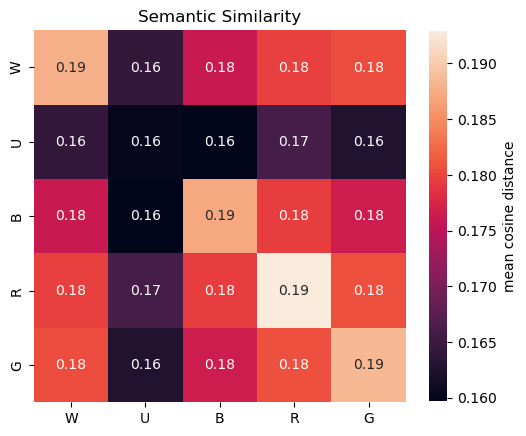

In [15]:
color_similarity_df = card_subsample.loc[:,['colors','W_mean_similarity','U_mean_similarity','B_mean_similarity','R_mean_similarity','G_mean_similarity']]
color_similarity_df['colors'] = color_similarity_df['colors'].explode()
color_similarity_df = color_similarity_df.groupby('colors').mean()
# Put back in WUBRG order:
color_similarity_df = color_similarity_df.loc[['W','U','B','R','G'],:]
# Make a heatmap
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(color_similarity_df.values, annot=True,
            xticklabels = colors,yticklabels=colors,
            square=True,cbar_kws={'shrink':0.8,'label':'mean cosine distance'})
plt.title('Semantic Similarity')
plt.show(block=False)

Overall there is very little variation in cosine similarity as a function of color. 

### Are there other aspects of a card's design that better explain its similarity in flavor to other cards? We can investigate this with clustering techniques

We are assuming that there are 5 true clusters in our data corresponding to the different colors (though that doesn't appear to be the case). First, let's cluster using k-means and see what 5 clusters pop out. 

In [16]:
# KMeans on embeddings with 5 clusters
from sklearn.cluster import KMeans

num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_
card_subsample['cluster'] = cluster_assignment

In [17]:
# Pie charts of card color breakdown by cluster:
color_codes = {'W':[221,209,185],
               'U':[47,153,208],
               'B':[71,80,71],
               'R':[174,76,69],
               'G':[83,128,96]}
color_codes = {c:list(np.array(color_codes[c])/255) for c in colors}
pie_colors = [color_codes[c] for c in colors]


colors
W     6
U     8
B    15
R     5
G    20
Name: count, dtype: int64
colors
W    51
U    40
B    31
R    36
G    28
Name: count, dtype: int64
colors
W    13
U    16
B    35
R    22
G    15
Name: count, dtype: int64
colors
W    14
U    19
B    10
R    18
G    19
Name: count, dtype: int64
colors
W    16
U    17
B     9
R    19
G    18
Name: count, dtype: int64


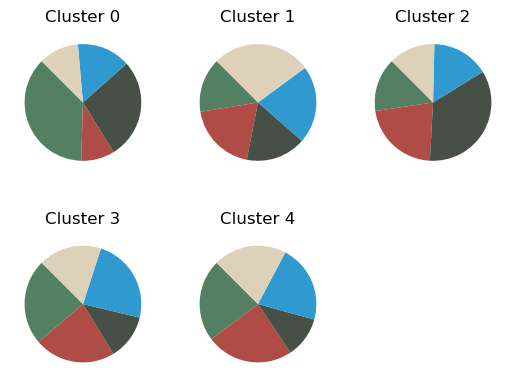

In [35]:
fig,axes = plt.subplots(2,3)
for i in range(5):
    cluster = i
    my_clust = card_subsample.loc[card_subsample['cluster']==cluster,:]
    color_breakdown = my_clust['colors'].explode().value_counts()
    # sort by color order:
    color_breakdown = color_breakdown[colors]
    ax_inds = np.unravel_index(i,(2,3))
    axes[ax_inds].pie(np.flip(color_breakdown),colors=np.flip(pie_colors,axis=0),startangle=135)
    axes[ax_inds].set_title(f'Cluster {cluster}')
    print(color_breakdown[colors])
# Remove unused 6th subplot
fig.delaxes(axes[1][2])

This type of clustering largely fails to separate cards in a way we expect. Though certain clusters are "enriched" in a specific color, no cluster is made up of a majority of any single color. 

Let's try a less supervised classification - hierarchical clustering with a dendrogram.

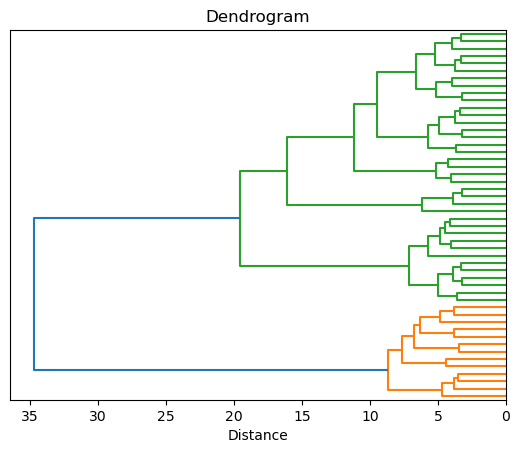

In [18]:
# Hierarchical clustering using the vote vectors (same as in our correlation matrix)
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(sim_np.T, method='ward')

plt.figure()
dendrogram(linkage_matrix,50,truncate_mode='lastp',
           no_labels=True,orientation='left',distance_sort=True)
plt.title('Dendrogram')
plt.xlabel('Distance')
plt.show()

This appears to find two major classes of flavor text.